In [1]:
# importing neccessary libraries

from pyspark import SparkConf
import matplotlib.pyplot as plt
import numpy as np
from pyspark.context import SparkContext
import pyspark as ps

conf = ps.SparkConf().setAppName('SparkApp').setMaster('local')
sc = SparkContext.getOrCreate(SparkConf())
# conf.set("spark.network.timeout", "600s")
# conf.set("spark.executor.heartbeatInterval","10000s")

In [2]:
# https://docs.databricks.com/dev-tools/databricks-connect.html#jupyter&language-java

from IPython.core.magic import line_magic, line_cell_magic, Magics, magics_class

@magics_class
class DatabricksConnectMagics(Magics):

   @line_cell_magic
   def sql(self, line, cell=None):
       if cell and line:
           raise ValueError("Line must be empty for cell magic", line)
       try:
           from autovizwidget.widget.utils import display_dataframe
       except ImportError:
           print("Please run `pip install autovizwidget` to enable the visualization widget.")
           display_dataframe = lambda x: x
       return display_dataframe(self.get_spark().sql(cell or line).toPandas())

   def get_spark(self):
       user_ns = get_ipython().user_ns
       if "spark" in user_ns:
           return user_ns["spark"]
       else:
           from pyspark.sql import SparkSession
           user_ns["spark"] = SparkSession.builder.getOrCreate()
           return user_ns["spark"]

ip = get_ipython()
ip.register_magics(DatabricksConnectMagics)

In [7]:
#preparing data 

filepath = "E:/Master Courses/2nd year/1st Semester/IR/2nd Assinment/test.txt"


# removing ( $, #, ), (, @, & ) symbols from the dataset
web_links = sc.textFile(filepath).filter(lambda x:"#" not in x).filter(lambda x:"(" not in x).filter(lambda x:")" not in x).filter(lambda x:"%" not in x).filter(lambda x:"&" not in x).filter(lambda x:"@" not in x).map(lambda x:x.split('\t'))

web_links.take(5)

[['0', '11342'],
 ['0', '824020'],
 ['0', '867923'],
 ['0', '891835'],
 ['11342', '0']]

In [8]:
# computing the rank of the nodes with nodes that refereing to.


def computeContribs (urls , rank):
    num_urls = len(urls)
    #contribs = []
    for url in urls:
        yield (url, rank / num_urls)
#contribs.append(url , rank/num_urls)  
   # return contribs

In [9]:
# Grouping by the same keys 

links = web_links.groupByKey().cache()

# .partitionBy(2)
# links.collect()

In [10]:
n = links.count()
print(n)

32


In [11]:
#intial step for all the nodes note that the ranks are stable in the first iteration
ranks = links.map(lambda url_neighbors: (url_neighbors[0], 1.0/n))
ranks.take(5)
#it has assigned one but for us is better to assign 1/number of nodes

[('0', 0.03125),
 ('867923', 0.03125),
 ('891835', 0.03125),
 ('1', 0.03125),
 ('276233', 0.03125)]

In [12]:
# defining the parameters 

alpha = 0.15
# alpha = 0.50
# alpha = 0.10
not_finished = True
threshold = 0.000001   # 10^-6
num_iterations = 0

In [13]:
# contribs = links.join(ranks).flatMap(lambda url_urls_rank:computeContribs(url_urls_rank[1][0], url_urls_rank[1][1]))
# contribs.take(5) 
    # Combine the result by key and sum them up.
    # multiply with alpha
    # Re-calculates URL ranks based on neighbor contributions.

#   rank2 = contribs.reduceByKey(lambda x,y : x + y).mapValues(lambda rank: rank * (1 - alpha) + (alpha / n))
# rank2 = contribs.reduceByKey(lambda x,y : x + y).mapValues(lambda rank: rank * (1 - alpha) + alpha / n).partitionBy(2)
# rank2.take(5)

# diff = rank2.join(ranks).mapValues(lambda x : abs(x[0]-x[1])).values().sum()
# print(diff)

In [16]:
# write the output into a local file
f = open('pagerank list.csv','w')

iterations=[]
difference=[]
while not_finished:
    num_iterations = num_iterations + 1
    
    # Calculates ranks of outdegree nodes.
    contribs = links.join(ranks).flatMap(lambda url_urls_rank:computeContribs(url_urls_rank[1][0], url_urls_rank[1][1]))
    
    rank2 = contribs.reduceByKey(lambda x , y : x + y).mapValues(lambda rank: rank * (1-alpha) + alpha / n ).partitionBy(2)
#     rank2.take(5)
   # compute the leaked rank and add them back to make sure the total rank is 1.

    PageRank_leak = 1 - rank2.values().sum()
    if PageRank_leak > 0 :
        updated_ranks = ranks.mapValues( lambda rank : rank + float ( PageRank_leak / n))
    else:
        updated_ranks = rank2

        
#     updated_ranks.take(3)


    # compute the difference ranks between this round and last round , decide whether to end the loop.
   
    diff = updated_ranks.join(ranks).mapValues(lambda x : abs(x[0]-x[1])).values().sum()
    print(rank2)
    print ('diff',diff)
    print ('Iteration : ',num_iterations)

    iterations.append(num_iterations)
    difference.append(diff)
    
    if diff < threshold:
        not_finished = False
#     elif num_iterations >= 100:
#         not_finished = False
    ranks = updated_ranks

    
f.write('Number of iterations : ' + str(num_iterations) + ' \nDifference ' + str(diff) + ' \n ' )
f.write('\nIds and Ranking Score in descending order '+'\n')    


for (usr, rank) in ranks.sortBy(lambda x:-x[1]).collect():
    print( "%s has rank = %s." % (usr, rank))
    f.write(str(usr)+' has rank = ' +str(rank)+'\n')

    
f.close()


597621 has rank = 0.01501798798117511.
644135 has rank = 0.01434078221453075.
430119 has rank = 0.01430284352457235.
30957 has rank = 0.01430284352457235.
565424 has rank = 0.014096303668148579.
462435 has rank = 0.014096303668148576.
581609 has rank = 0.014024577284292006.
858904 has rank = 0.013940745185497299.
423174 has rank = 0.013940745185497299.
2 has rank = 0.013940745185497299.
357310 has rank = 0.013940745185497299.
472889 has rank = 0.013940745185497299.
173976 has rank = 0.008094260703412261.
795253 has rank = 0.008094260703412261.
670449 has rank = 0.008094260703412261.
746182 has rank = 0.008094260703412261.
867923 has rank = 0.007695781557711853.
891835 has rank = 0.00759529900281085.
11342 has rank = 0.0073224996168846194.
62391 has rank = 0.0073168458335928915.
4 has rank = 0.007217812092214631.
44695 has rank = 0.007217812092214631.
79146 has rank = 0.007217812092214631.
53051 has rank = 0.007208126773136567.
223236 has rank = 0.007208126773136567.
748615 has rank = 0

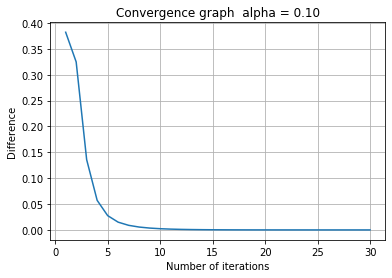

In [15]:
plt.plot(iterations,difference)
plt.title('Convergence graph  alpha = 0.15')
plt.xlabel('Number of iterations')
plt.ylabel('Difference')
ax = plt.gca()
# ax.set_ylim([-0.00001,0.1])
# ax.set_xlim([0,15])
plt.grid()
plt.savefig('Convergence_graph_alpha=0.15.png')


In [19]:
# References:
# https://github.com/apache/spark/blob/master/examples/src/main/python/pagerank.py
# https://github.com/chenyb59/big-data-processing/blob/master/pagerank/pg_Twitter.py
# 